In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from glob import glob
import os 
from tqdm import tqdm
import shutil

In [2]:
!pip install -q torchxrayvision

In [3]:
import torchxrayvision as xrv

/opt/conda/lib/python3.10/site-packages/torchxrayvision/utils.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
df = pd.read_csv('/kaggle/input/padchest-small-dataset/PC/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv')
df = df[df['Projection'].isin(['PA','AP'])]
print(display(df))

,Unnamed: 0,ImageID,ImageDir,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,Projection,...,ExposureTime,RelativeXRayExposure_DICOM,ReportID,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,labelCUIS,LocalizationsCUIS
0,0,20536686640136348236148679891455886468_k6ga29.png,0,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930.0,F,POSTEROANTERIOR,PA,...,10.0,-1.42,4765777,sin hallazg patolog edad pacient .,Physician,['normal'],[],"[['normal'], ['normal']]",[],[]
2,2,135803415504923515076821959678074435083_fzis7b...,0,20150914,135803415504923515076821959678074435083,313572750430997347502932654319389875966,1929.0,M,POSTEROANTERIOR,PA,...,10.0,NaN,4991845,cambi pulmonar cronic sever . sign fibrosis b...,Physician,"['pulmonary fibrosis', 'chronic changes', 'kyp...","['loc basal', 'loc basal bilateral']","[['pulmonary fibrosis', 'loc basal bilateral']...",['C0034069' 'C0742362' 'C2115817' 'C3544344'],['C1282378']
3,3,113855343774216031107737439268243531979_3k951l...,0,20150717,113855343774216031107737439268243531979,50783093527901818115346441867348318648,1925.0,F,POSTEROANTERIOR,PA,...,8.0,NaN,4955977,. . siluet cardi mediastin dentr normal . cam...,Physician,['chronic changes'],"['loc cardiac', 'loc mediastinum', 'loc costop...","[['chronic changes'], ['chronic changes'], ['n...",['C0742362'],['C1522601' 'C0025066' 'C0230151']
5,5,313903302629300007485735352869488750471_75sg0k...,0,20170125,313903302629300007485735352869488750471,3707275269754751392247446521222810702,1978.0,M,NaN,AP,...,NaN,1192.00,5310833,objet mejori radiolog con practic resolucion ...,Physician,"['unchanged', 'alveolar pattern', 'interstitia...","['loc basal', 'loc left']","[['unchanged'], ['alveolar pattern', 'intersti...",['C1332240' 'C2073538'],['C1282378' 'C0443246']
7,7,3137231742710829928-247610802266403640553_kine...,0,20150804,3137231742710829928-247610802266403640553,93535126770783451980359712286922420997,1957.0,M,NaN,PA,...,0.0,299.00,4969767,radiografi actual comp con previ 26 juni pers...,Physician,"['laminar atelectasis', 'pleural effusion', 'a...","['loc basal', 'loc subsegmental', 'loc pleural...","[['laminar atelectasis', 'loc subsegmental', '...",['C2073625' 'C4305366' 'C0185792'],['C1282378' 'C0929165' 'C0032225' 'C0444532' '...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160852,160852,1284011361929414522079841201696751542351444145...,49,20090714,1284011361929414522079841201696751542351444145...,178941107688363238116741298870229076976,1958.0,F,POSTEROANTERIOR,PA,...,10.0,-0.99,3611530,motiv consult neo mam seguimient . radiografi...,RNN_model,['normal'],[],"['exclude', 'normal', 'normal']",[],[]
160856,160856,1284011361929414522814654121696751542351444145...,49,20110321,1284011361929414522814654121696751542351444145...,112930952416074060371371014599496493673,1948.0,M,POSTEROANTERIOR,PA,...,10.0,-0.69,4018689,import sign radiolog epoc . pinzamient ambos ...,RNN_model,"['COPD signs', 'costophrenic angle blunting']",['loc costophrenic angle'],"['COPD signs', 'costophrenic angle blunting', ...",['C0024117' 'C0742855'],['C0230151']
160857,160857,1284011361929414522094646571696751542351444145...,49,20090609,1284011361929414522094646571696751542351444145...,282743729971423358706056731890510600934,1944.0,F,POSTEROANTERIOR,PA,...,10.0,-0.85,3639865,dentr normal .,RNN_model,['normal'],[],['normal'],[],[]
160859,160859,1284011361929414522084108901696751542351444145...,49,20101214,1284011361929414522084108901696751542351444145...,228646130593152933811948996634154201216,1943.0,F,POSTEROANTERIOR,PA,...,10.0,-1.00,3958189,dentr normal .,RNN_model,['normal'],[],['normal'],[],[]


None


In [5]:
df['Patient Age'] = 2024 - df['PatientBirth'] 

In [6]:
df = df[['ImageID','PatientID','Projection','Labels','Patient Age']]
df = df.dropna().reset_index(drop=True) 

In [7]:
df['Labels'] = df['Labels'].apply(ast.literal_eval)
df['Labels'] = df['Labels'].apply(lambda x: [label.strip() for label in x])

In [8]:
df[df['Labels'].apply(lambda x: 'normal' in x)]['Labels'].value_counts()

Labels
[normal]                                                                                                             34878
[cardiomegaly, normal]                                                                                                  11
[infiltrates, normal]                                                                                                    8
[nodule, normal]                                                                                                         3
[, normal]                                                                                                               3
                                                                                                                     ...  
[COPD signs, normal, kyphosis, vertebral anterior compression]                                                           1
[normal, unchanged, alveolar pattern, cardiomegaly, costophrenic angle blunting, interstitial pattern, pneumonia]        1
[COPD sig

In [9]:
allowed_labels = ['normal',
                  'pleural effusion', 'loculated pleural effusion', 'pericardial effusion', 'loculated fissural effusion',
                  'pneumothorax', 'hydropneumothorax',
                  'consolidation',
                  'pulmonary fibrosis', 
                  'emphysema', 'subcutaneous emphysema',
                  'pulmonary edema', 
                  'atelectasis', 'laminar atelectasis','lobar atelectasis','segmental atelectasis',
                  'cardiomegaly',
                  'pneumonia','atypical pneumonia',]

In [10]:
tmp = df['Labels'].explode()

filtered_tmp = tmp.apply(lambda x: x if x in allowed_labels else None).dropna()
filtered_tmp = filtered_tmp.groupby(filtered_tmp.index).agg('|'.join)

df = df.loc[filtered_tmp.index]
df['Labels'] = filtered_tmp

In [11]:
def label_concat(row):
    if row in ['normal']:
        return 'No Finding'
    elif row in ['pleural effusion', 'loculated pleural effusion', 'pericardial effusion', 'loculated fissural effusion']:
        return 'Effusion'
    elif row in ['pneumothorax', 'hydropneumothorax']:
        return 'Pneumothorax'
    elif row in ['consolidation']:
        return 'Consolidation'
    elif row in ['pulmonary fibrosis']:
        return 'Fibrosis'
    elif row in ['emphysema', 'subcutaneous emphysema']:
        return 'Emphysema'
    elif row in ['pulmonary edema']:
        return 'Edema'
    elif row in ['atelectasis', 'laminar atelectasis','lobar atelectasis','segmental atelectasis']:
        return 'Atelectasis'
    elif row in ['cardiomegaly']:
        return 'Cardiomegaly'
    elif row in ['pneumonia','atypical pneumonia']:
        return 'Pneumonia'

In [12]:
tmp = df['Labels'].str.split('|').explode()

df['Labels'] = tmp.apply(lambda x: label_concat(x)).groupby(tmp.index).agg('|'.join)

In [13]:
df = df.reset_index(drop=True)

In [14]:
%%time
tmp = {os.path.basename(x): x for x in glob('/kaggle/input/*/PC/images-224/images-224/*')}    
    
df['path'] = df['ImageID'].map(tmp)

CPU times: user 986 ms, sys: 282 ms, total: 1.27 s
Wall time: 15.8 s


In [15]:
df = df[~df['Labels'].apply(lambda x: '|No Finding' in x)]
df = df[~df['Labels'].apply(lambda x: 'No Finding|' in x)]

In [16]:
tmp = df.groupby('PatientID')['Labels'].nunique()
tmp = tmp.reset_index().rename(columns={'Labels':'label_nunique'})

df = df.merge(tmp, on='PatientID', how='left')

tmp1 = df.loc[df['label_nunique'] > 1][df['Labels'] != 'No Finding']
tmp2 = df.loc[df['label_nunique'] == 1]

df = pd.concat([tmp1, tmp2], axis=0).reset_index(drop=True)

In [17]:
tmp1 = df[df['Labels'] == 'No Finding'].sample(10_000, random_state=42)
tmp2 = df[df['Labels'] != 'No Finding']

df = pd.concat([tmp1,tmp2])
df = df.reset_index(drop=True)

In [18]:
df['Projection'].value_counts()

Projection
PA    28344
AP     2030
Name: count, dtype: int64

In [19]:
df['Labels'].str.split('|').explode().value_counts()

Labels
No Finding       10000
Cardiomegaly      8757
Atelectasis       4503
Effusion          4192
Pneumonia         3939
Consolidation     1071
Emphysema          967
Fibrosis           683
Edema              462
Pneumothorax       305
Name: count, dtype: int64

In [20]:
df['Image Index'] = df['ImageID']
df['Patient ID'] = df['PatientID']
df['View Position'] = df['Projection']
df['Finding Labels'] = df['Labels']

df = df[['Image Index','Patient ID','View Position','Finding Labels','Patient Age','path']]

In [21]:
df = df.dropna().reset_index(drop=True)
df.to_csv('metadata.csv', index=False)

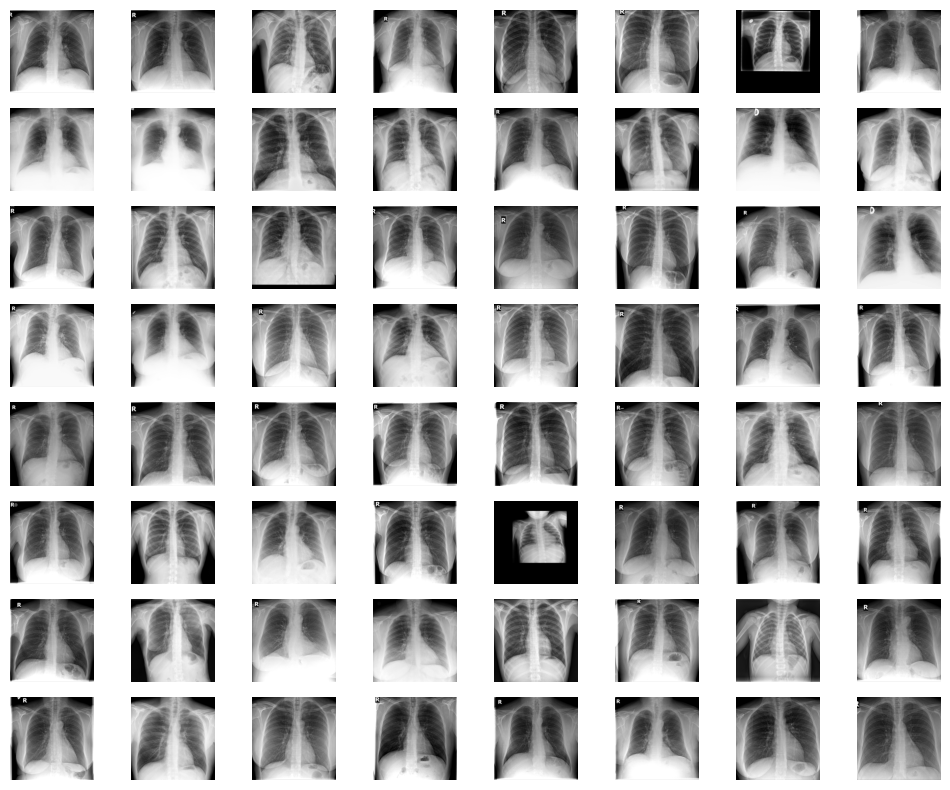

In [22]:
from PIL import Image

plt.figure(figsize=(10,8))


for i in range(64):
    plt.subplot(8,8,i+1)
    path = df.iloc[i]['path']
    img = Image.open(path)
    img = np.array(img)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [23]:
PATH = '/kaggle/working/lung_diseases/'

os.makedirs(os.path.join(PATH), exist_ok=True)
    
sub_count = 0
    
for i, file in enumerate(tqdm(df['path'].unique())):
    index = df[df['path'] == file]['Image Index'].values[0]
    
    if (i == 0) or (i % 5000 == 0):
        sub_count += 1
        sub_path = os.path.join(PATH, f'image_00{sub_count}')
        os.makedirs(sub_path, exist_ok=True)
    
    shutil.copy(file, os.path.join(sub_path, index))

100%|██████████| 30372/30372 [10:51<00:00, 46.59it/s]
